### Load required libraries

In [1]:
import os
import urllib, cStringIO
import pymongo as pm

## plotting libraries
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64
from glob import glob

from scipy.spatial import distance

### Load VGG feature analysis libraries and scripts

In [2]:
# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [3]:
# Retrieve sketch paths -- pngs rendered out in another step
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = 'srcd-features/museumstation_sketches'
sketch_paths = sorted(list_files(path_to_sketches))

## number of sketch paths 
print 'Number of sketch paths = {} before filtering'.format(len(sketch_paths))
png_sketch_count = len(sketch_paths)

Number of sketch paths = 8037 before filtering


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>

In [4]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalizes features first
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('srcd-features/museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('srcd-features/museumstation_features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

def flatten(x):
    return [item for sublist in x for item in sublist]


### Get sorting indexes for plotting dprimes and RDMs

In [5]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6

## load in kid features
KF, KM = load_features('kid',layer_ind)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

excluded_drawing_number = png_sketch_count - feature_sketch_count
print 'Number of excluded drawings = {}'.format(excluded_drawing_number)

Number of unique kids who contributed drawings = 1447
Number of features for 7326 images in layer 6 = 4096
Number of excluded drawings = 711


In [6]:
_labels = np.unique(KM.label.values)
ordered_objs = ['an airplane', 'a bike', 'a car', 'a boat', 'a chair', 'a couch', 'a house', 'a cup', 'a bowl', 'a phone', 'a person', 'a bird', 'a dog', 'a fish', 'a rabbit', 'a tree']
ordered_objs = np.asarray(ordered_objs)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

In [15]:
for age in range(2,11):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    print 'We have {} {}-year olds who contributed {} drawings'.format(np.shape(np.unique(KM_subset['session']))[0],age, np.shape(KM_subset)[0])

We have 207 2-year olds who contributed 729 drawings
We have 271 3-year olds who contributed 1266 drawings
We have 218 4-year olds who contributed 1049 drawings
We have 196 5-year olds who contributed 1115 drawings
We have 161 6-year olds who contributed 933 drawings
We have 113 7-year olds who contributed 649 drawings
We have 108 8-year olds who contributed 582 drawings
We have 68 9-year olds who contributed 409 drawings
We have 105 10-year olds who contributed 594 drawings


### Define subfunctions relevant for calculating RDMs and dprime metrics

In [22]:
def get_class_mean_vectors(F,M,ordered_objs):
    class_means = np.zeros([np.shape(ordered_objs)[0], np.shape(F)[1]])
    for ci, class_label in enumerate(ordered_objs): # go through each list of classes
            class_features = F[M.label.values==class_label]
            class_means[ci] = np.median(class_features, axis=0); # MEDIAN ovver rows, i.e. images
    return(class_means)

In [23]:
def get_all_image_distinctiveess(F,M,ordered_objs, class_medians):    
    discrim_all_images=[]
    for ci, target_class in enumerate(ordered_objs): # go through each list of classes
        # get target class mean
        target_class_features = F[M.label.values==target_class]
        target_class_median = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images    

        # open variables
        num_target_images=np.shape(target_class_features)[0];
        dist_conf = np.zeros(np.shape(ordered_objs)[0]) 
        discrim_target_conf = np.zeros(num_target_images)
        dist_conf_relative = np.zeros(np.shape(ordered_objs)[0]) 
    
        # for each image, get distance to category mean and to distractor means; subdtract and sum
        for vi in range(num_target_images): 
            dist_target = distance.euclidean(target_class_features[vi],target_class_median) ## get euclidean distance to mean
            for ci, class_label in enumerate(ordered_objs): # go through each list of classes
                conf_class_median = class_medians[ci,:]
                dist_conf[ci] = distance.euclidean(target_class_features[vi],conf_class_median) ## get euclidean distance to conf mean
                dist_conf_relative[ci] = dist_conf[ci] - dist_target
            discrim_target_conf[vi]=np.sum(dist_conf_relative) ## subtract -- higher values: more discrim
        
        discrim_all_images = np.concatenate(discrim_all_images,discrim_target_conf)
    return discrim_all_images

In [24]:
def get_image_distinctiveess(F,M,target_class,ordered_objs, class_medians):    
    # get target class mean
    target_class_features = F[M.label.values==target_class]
    target_class_median = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images    
    
    # open variables
    num_target_images=np.shape(target_class_features)[0];
    dist_conf = np.zeros(np.shape(ordered_objs)[0]) 
    discrim_target_conf = np.zeros(num_target_images)
    dist_conf_relative = np.zeros(np.shape(ordered_objs)[0]) 
    
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        dist_target = distance.euclidean(target_class_features[vi],target_class_median) ## get euclidean distance to mean
        for ci, class_label in enumerate(ordered_objs): # go through each list of classes
            conf_class_median = class_medians[ci,:]
            dist_conf[ci] = distance.euclidean(target_class_features[vi],conf_class_median) ## get euclidean distance to conf mean
            dist_conf_relative[ci] = dist_conf[ci] - dist_target
        discrim_target_conf[vi]=np.sum(dist_conf_relative) ## subtract -- higher values: more discrim
    return discrim_target_conf

In [25]:
# Gets mean of each class (e.g., category) in a feature space
def get_class_means_bl(F, M):  # just adapted to take in features and metadata directly  
    X = F;
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

# Gets "std" of each class (e.g., category) in a feature space
def get_class_std(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    # open variables
    _dist = np.zeros(num_images)   
    _dist_sq = np.zeros(num_images) 
    # for each image, get distance to category mean and square it
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get euclidean distance to mean
        _dist_sq[vi] = _dist[vi]**2 # square each distance
    dist_sum = sum(_dist_sq) / num_images; # sum these distances and divide by the number of IMAGES
    return np.sqrt(dist_sum) #  get square root to make it a std (RMSE)

def get_class_distances(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    # open variables
    _dist = np.zeros(num_images)   
    _dist_sq = np.zeros(num_images) 
    # for each image, get distance to category mean and square it
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get euclidean distance to mean
        _dist_sq[vi] = _dist[vi]**2 # square each distance
    return (_dist_sq) # should be numImages x their squared deviations

# Use mean and std to compute a higher-dimensional d-prime matrix
def get_class_dprime(class_std, class_means,ordered_objs):
    d_prime = np.zeros((len(np.unique(ordered_objs)), len(np.unique(ordered_objs)))); # n-class x n-class matrix      
    for i, v in enumerate(ordered_objs): # go through each list of classes
        for i2, v2 in enumerate(ordered_objs): # and each pair of classes
            if i==i2: # if we're in the diagonal
                d_prime[i,i2] = 0; # give dummy value when looking at same category, 0 = the same category
            else:
                sd1=class_std[i]; sd2=class_std[i2]; # grab class variance for each pair of categories
                m1=class_means[i];  m2=class_means[i2]; # grab class means for each pair of categories
                num = distance.euclidean(m1,m2) # distance between two mean vectors
                denom = np.sqrt(.5*(sd1**2+sd2**2)); # calculate denominator 
                d=num/denom;
                d_prime[i,i2] = d;  # fill in matrix
    return d_prime;

def get_class_rmse_only(class_std, class_means,ordered_objs):
    rmse = np.zeros((len(np.unique(ordered_objs)), len(np.unique(ordered_objs)))); # n-class x n-class matrix      
    for i, v in enumerate(ordered_objs): # go through each list of classes
        for i2, v2 in enumerate(ordered_objs): # and each pair of classes
            if i==i2: # if we're in the diagonal
                rmse[i,i2] = 0; # give dummy value when looking at same category, 0 = the same category
            else:
                sd1=class_std[i]; sd2=class_std[i2]; # grab class variance for each pair of categories
                m1=class_means[i];  m2=class_means[i2]; # grab class means for each pair of categories
                num = distance.euclidean(m1,m2) # distance between two mean vectors
                denom = np.sqrt(.5*(sd1**2+sd2**2)); # calculate denominator of dprime -- rmse
                rmse[i,i2] = denom;
    return rmse; 

def get_class_mdm(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_median = np.median(class_features, axis=0) # MEDIAN ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    # open variables
    _dist = np.zeros(num_images)   
    _dist_sq = np.zeros(num_images) 
    # for each image, get distance to category mean and square it
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_median) ## get euclidean distance to mean
        _dist_sq[vi] = _dist[vi]**2 # square each distance
    _dist_median = np.median(_dist_sq)
    return np.sqrt(_dist_median) #  get std?


def get_two_class_discrim(F,M,target_class,confusion_class):    
    target_class_features = F[M.label.values==target_class]
    target_class_mean = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    num_target_images=np.shape(target_class_features)[0];
    
    conf_class_features = F[M.label.values==confusion_class]
    conf_class_mean = np.median(conf_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    
    # open variables
    dist_target = np.zeros(num_target_images)   
    dist_conf = np.zeros(num_target_images) 
    discrim_target_conf = np.zeros(num_target_images)
    
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        dist_target[vi] = distance.euclidean(target_class_features[vi],target_class_mean) ## get euclidean distance to mean
        dist_conf[vi] = distance.euclidean(target_class_features[vi],conf_class_mean) ## get euclidean distance to conf mean
        discrim_target_conf[vi]=dist_conf[vi]-dist_target[vi] ## subtract -- higher values: more discrim
    return np.mean(discrim_target_conf)

def show_confMatrix(confMatrix,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
    plt.matshow(confMatrix, vmin=-2, vmax=10) # maximum pairwise value in data?
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 12);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 12); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/RMSE_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

### Try getting image wise distinctiveness

In [26]:
class_means = get_class_mean_vectors(KF,KM,ordered_objs)

In [27]:
distinctiveness = []
ages = []
class_labels=[]
for ci, class_label in enumerate(ordered_objs):
    this_dist = get_image_distinctiveess(KF,KM,class_label,ordered_objs,class_means)
    ind = KM.index[KM['label'] == class_label]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    age_subset = KM_subset['age'].values
    labels_subset = KM_subset['label'].values
    class_labels.extend(labels_subset)
    ages.extend(age_subset)
    distinctiveness.extend(this_dist)

In [31]:
## make into data frame
# distinctiveness = pd.to_numeric(distinctiveness)
data = [ages, distinctiveness, class_labels]
df = pd.DataFrame(data)
df = df.transpose()
df.columns=['ages','distinctiveness','class_labels']
df.to_csv('distinctiveness_try.csv')

NameError: name 'get_two_class_discrim' is not defined

In [32]:
# df['distinctiveness'] = pd.to_numeric(df['distinctiveness'])
# g = sns.factorplot(x="ages", y="distinctiveness", hue="ages", data=df, 
#                    kind="violin", size=22, aspect=4)

### Look at distance metrics by age

In [138]:
def get_two_class_discrim(F,M,target_class,confusion_class):    
    target_class_features = F[M.label.values==target_class]
    target_class_mean = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    num_target_images=np.shape(target_class_features)[0];
    
    conf_class_features = F[M.label.values==confusion_class]
    conf_class_mean = np.median(conf_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    
    # open variables
    dist_target = np.zeros(num_target_images)   
    dist_conf = np.zeros(num_target_images) 
    discrim_target_conf = np.zeros(num_target_images)
    
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        dist_target[vi] = distance.euclidean(target_class_features[vi],target_class_mean) ## get euclidean distance to mean
        dist_conf[vi] = distance.euclidean(target_class_features[vi],conf_class_mean) ## get euclidean distance to conf mean
        discrim_target_conf[vi]=dist_conf[vi]-dist_target[vi] ## subtract -- higher values: more discrim
    return np.mean(discrim_target_conf)

def get_imagewise_two_class_discrim(F,M,target_class,confusion_class):    
    target_class_features = F[M.label.values==target_class]
    target_class_mean = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    num_target_images=np.shape(target_class_features)[0];
    
    conf_class_features = F[M.label.values==confusion_class]
    conf_class_mean = np.median(conf_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    
    # open variables
    dist_target = np.zeros(num_target_images)   
    dist_conf = np.zeros(num_target_images) 
    discrim_target_conf = np.zeros(num_target_images)
    ages = np.zeros(num_target_images)
    
    ## target_category meta data
    ind = M.index[M.label.values==target_class]
    M_subset =  M.loc[ind]

    session_id = []
    target_label = []
    conf_label = []
    
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        conf_label.append(confusion_class)  
        target_label.append(M_subset['label'].values[vi])  
        ages[vi] = M_subset['age'].values[vi]
        session_id.append(M_subset['session'].values[vi])
        dist_target[vi] = distance.euclidean(target_class_features[vi],target_class_mean) ## get euclidean distance to mean
        dist_conf[vi] = distance.euclidean(target_class_features[vi],conf_class_mean) ## get euclidean distance to conf mean

    out = pd.DataFrame([dist_target,dist_conf,session_id,ages, target_label, conf_label])    
    out = out.transpose()
    out = out.rename(index=str, columns={0: "dist_target", 1: "dist_conf", 2:"session_id", 3:"age", 4:"target_class_label", 5:"conf_class_label"})
    return (out)

In [146]:
target_label = "a person"
conf_label = "a bowl"
for age in (2,3,4,5,6,7,8,9,10):
    agei=age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
#     print(np.shape(KF_subset))
    temp = get_imagewise_two_class_discrim(KF_subset,KM_subset,target_label,conf_label)
    print np.shape(temp)
    if agei==0:
        out=temp
    else:
        out = pd.concat([out,temp])
#         print np.shape(out)

out.to_csv('{}_v_{}_by_age.csv'.format(target_label,conf_label))  

(44, 6)
(80, 6)
(124, 6)
(57, 6)
(181, 6)
(65, 6)
(246, 6)
(47, 6)
(293, 6)
(35, 6)
(328, 6)
(36, 6)
(364, 6)
(26, 6)
(390, 6)
(25, 6)
(415, 6)


In [126]:
ind = KM.index[KM.label.values=="a rabbit"]
M_subset =  KM.loc[ind]
M_subset['age'].values[1]

2

In [ ]:
### Get confusiong matrixes by age

In [11]:
confMatrixbyAge = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0],9])
for age in (2,3,4,5,6,7,8,9,10):
    agei=age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    plt.figure(age,figsize=(18,12))
    
    confMatrix = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0]])
    for t, target_label in enumerate(ordered_objs):
        for c, conf_label in enumerate(ordered_objs):
            confMatrix[t,c]=get_two_class_discrim(KF_subset,KM_subset,target_label,conf_label)  
    
    print np.mean(confMatrix[np.where(~np.eye(confMatrix.shape[0],dtype=bool))])
    confMatrixbyAge[:,:,agei]=confMatrix


1.80550602215
1.64739763642
2.86658295458
4.65215876902
4.79461618418
5.49237238933
5.69836466391
5.89237217957
5.83481068446


2
3
4
5
6
7
8
9
10


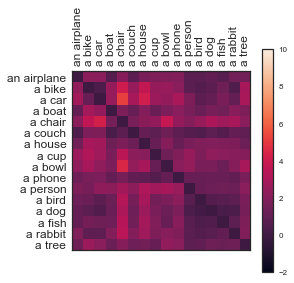

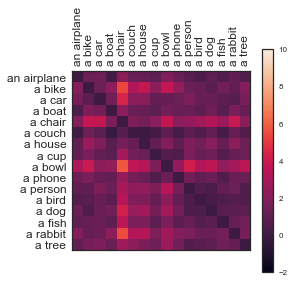

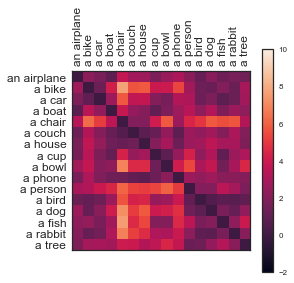

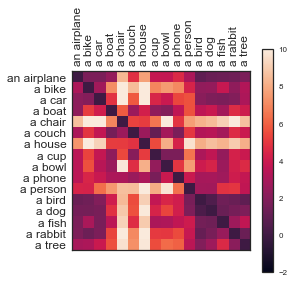

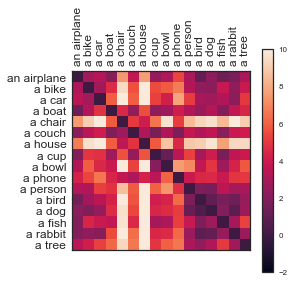

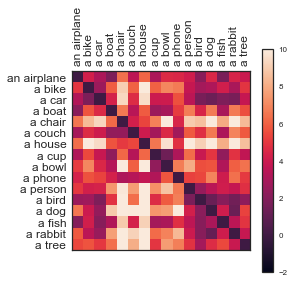

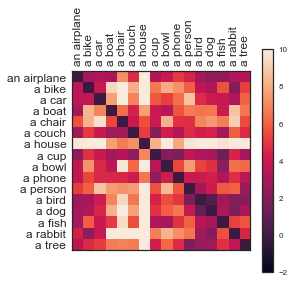

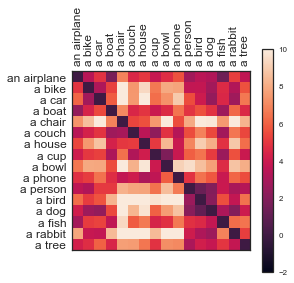

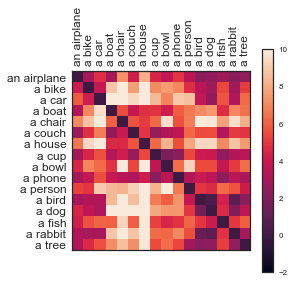

In [12]:
for age in (2,3,4,5,6,7,8,9,10):
    print age
    agei=age-2
    show_confMatrix(confMatrixbyAge[:,:,agei],ordered_objs,age)

In [32]:
class_distances=np.zeros([np.shape([2,3,4,5,6,7,8,9,10])[0],16])
np.shape(class_distances)

(9, 16)

In [36]:
## Look at distances each age group
# for age in (5,9):
#     print age
agei=0
class_distances=np.zeros([10,16])

for age in (2,3,4,5,6,7,8,9,10):
    agei=agei+1
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    plt.figure(age,figsize=(18,12))

    _labels = np.unique(KM.label.values)
    for l, this_label in enumerate(_labels):
        these_distances = get_class_distances(KF_subset,KM_subset,this_label)
        class_distances[agei,l]=these_distances.mean()
        
#         sns.distplot(these_distances, hist = False, kde = True,
#              kde_kws = {'linewidth': 1,  'shade': False,},
#              label = this_label)
#         plt.legend(prop={'size': 12}, title = 'Category')
#         plt.ylim([0,np.max(these_distances)])
        
#         plt.hist(these_distances)
#         plt.plot(np.log(these_distances))
#         plt.ylim([0,.001])
#         plt.title('age'+ ' '+ str(age))
#         plt.savefig('./plots/Class_distance_distribution_by_age_{}.pdf'.format(age), bbox_inches="tight")




### Try imagewise MDS

In [ ]:
## Import libaries
from sklearn.metrics import pairwise
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
seed = np.random.RandomState(seed=3)

### Single class MDS at each age

In [ ]:
## Make an MDS plot of birds at each ages
# for age in (2,3,4,5,6,7,8,9,10):
#     ind = KM.index[KM['age'] == age]
#     KM_subset =  KM.loc[ind]
#     KF_subset =  KF[ind.tolist()]
    
#     class_features = KF_subset[KM_subset.label.values=="a bird"] 
#     imagewise_distances = pairwise.euclidean_distances(class_features)

#     mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
#                    dissimilarity="precomputed", n_jobs=1)
#     pos = mds.fit(imagewise_distances).embedding_

#     plt.figure(age)
#     s = 20 ## size of the dots
#     plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
#     plt.title('age ' + str(age))

### Look at multi-class MDS for each age

NameError: name 'pairwise' is not defined

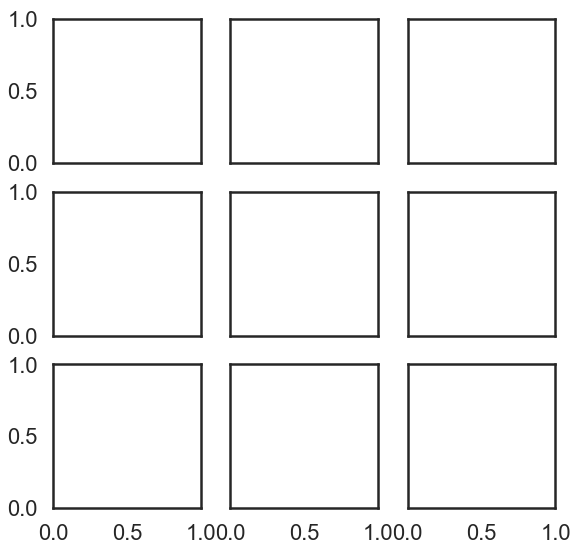

In [33]:
first_class='a person'
second_class='a cup'
third_class='a house'
fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharey=True, sharex=True)

for agei, age in enumerate(range(2,11)):
    ## Subset to the age and classes of interest
    ind = KM.index[KM['age'] == age] & (KM.index[KM.label.values==first_class] | KM.index[KM.label.values==second_class] | KM.index[KM.label.values==third_class])
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    plotColors = np.zeros([np.size(KM_subset.label),3])
    for i,v in enumerate(np.asarray(KM_subset.label)):
        if v==first_class:
            plotColors[i]=[255,0,0]
        elif v==second_class:
            plotColors[i]=[0,0,255]
        elif v==third_class:
            plotColors[i]=[0,255,0]
    
    ## Compute distances on this subset
    subset_distances = pairwise.euclidean_distances(KF_subset)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(subset_distances).embedding_
    s = 10 ## size of the dots
    ## sublot indexes, messy but OK for now
    if agei<3: ## 0,1,2
        plot_row=0
        plot_col=agei
    elif (agei>2) and (agei<6):
        plot_row=1
        plot_col=agei-3  
    elif agei>5: # 6,7,8
        plot_row=2
        plot_col=agei-6
    else:
        error('badly specified plots')
    
    axs[plot_row,plot_col].scatter(pos[:, 0], pos[:, 1], c=plotColors/255.0, s=s, lw=0, label='MDS')
#     axs[agei].title('age' + str(age) + " " + first_class + " vs. "+ second_class)
    axs[plot_row,plot_col].set_xlim([-200,200])
    axs[plot_row,plot_col].set_ylim([-200,200])
    axs[plot_row,plot_col].set_title('age' + str(age))
    
plt.savefig('./plots-MDS/Distance_MDS_{}_{}_{}.pdf'.format(first_class,second_class,third_class), bbox_inches="tight")


In [ ]:
np.unique(KM_subset.age)[0]

In [ ]:
# class_features = KF[KM.label.values==this_item] 
# imagewise_distances = pairwise.euclidean_distances(class_features)

# mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
#                    dissimilarity="precomputed", n_jobs=1)
# pos = mds.fit(imagewise_distances).embedding_

# plt.figure(age)
# s = 20 ## size of the dots
# plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
# plt.title('all ages' + this_item)

### Look at which items are far vs. close to the center of a category

In [ ]:
## Get all squared distances in a given class 
avg_bird = np.where(bird_distances == np.min(bird_distances))
weird_bird = np.where(bird_distances == np.max(bird_distances))
M_bird = KM_subset[KM_subset.label.values=='a bird']

In [ ]:
bird_distances.sort()
plt.hist(bird_distances)

In [ ]:
bird_distances[weird_bird]  == np.max(bird_distances)
M_bird.session.values[weird_bird]

In [ ]:
bird_distances.sort()
this_bird = np.where(bird_distances == bird_distances[-22])
M_bird.session.values[this_bird]

In [ ]:
bird_distances.sort()
this_bird = np.where(bird_distances == np.min(bird_distances))
M_bird.session.values[this_bird]

### How consistent are category distance measures across age?

In [ ]:
# for age in range(2,11):
#     ind = KM.index[KM['age'] == age]
#     KM_subset =  KM.loc[ind]
#     KF_subset =  KF[ind.tolist()]
#     class_means = np.zeros(np.shape(class_list)[0])
#     class_std = np.zeros(np.shape(class_list)[0]) 
#     #
#     class_means = get_class_means_bl(KF_subset, KM_subset)
#     ordered_means = class_means[sort_inds,:] # order these in same order!! 

#     agei = age-2
#     for l, this_label in enumerate(ordered_objs): # goes through ordered list
#         class_std[l] = get_class_std(KF_subset,KM_subset,this_label)

### Calculate dprime in each age group

In [15]:
dprime_this_age = get_class_dprime(class_std, ordered_means, ordered_objs)
np.shape(dprime_this_age)

NameError: name 'class_std' is not defined

In [16]:
dim=16
class_list = np.asarray(np.unique(KM.label.values))
dprime_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
rmse_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
rmse_avg_by_age = np.zeros(np.shape(range(2,11)))
rmse_std_by_age = np.zeros(np.shape(range(2,11)))
dprime_avg_by_age = np.zeros(np.shape(range(2,11)))
class_std_by_age = np.zeros([np.shape(class_list)[0],np.shape(range(2,11))[0]])

for age in range(2,11):
#     print age
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    class_means = np.zeros(np.shape(class_list)[0])
    class_std = np.zeros(np.shape(class_list)[0]) 
    #
    class_means = get_class_means_bl(KF_subset, KM_subset)
    ordered_means = class_means[sort_inds,:] # order these in same order!! 

    agei = age-2
    for l, this_label in enumerate(ordered_objs): # goes through ordered list
        class_std[l] = get_class_mdm(KF_subset,KM_subset,this_label)
    class_std_by_age[:,agei] = class_std
    dprime_this_age = get_class_dprime(class_std, ordered_means, ordered_objs)
    rmse_this_age = get_class_rmse_only(class_std,ordered_means, ordered_objs)
    dprime_by_age[:,:,agei] = dprime_this_age
    rmse_by_age[:,:,agei] = rmse_this_age
    dprime_avg_by_age[agei] = np.mean(np.ravel(dprime_this_age[np.triu_indices(dim,k=1)]))
    rmse_avg_by_age[agei] = np.mean(np.ravel(rmse_this_age[np.triu_indices(dim,k=1)]))
    rmse_std_by_age[agei] = np.std(np.ravel(rmse_this_age[np.triu_indices(dim,k=1)]))


In [ ]:
ordered_objs

In [ ]:
for l, this_label in enumerate(ordered_objs):
    matplotlib.pyplot.plot(np.arange(2,11),class_std_by_age[l,:])
    np.std(class_std_by_age[l,:])
    
sns.color_palette("muted")
sns.set()
## relative distances between categories -- correlation metric
## absolute distances between categories -- nominator


### Output average d-prime stats across category pairings

In [ ]:
dim = 16
for agei in range(0,9):
    print 'average d prime of {} year old = {} '.format(agei+2, np.round(dprime_avg_by_age[agei],2))
#     print 'max d prime of {} year old = {} '.format(agei+2,round(np.max(dprime_by_age[agei]),2))
#     print ' {}-yrs, M={}'.format(agei+2, np.round(dprime_avg_by_age[agei],2))

In [ ]:
dim = 16
for agei in range(0,9):
    print 'average rmse of {} year old = {} '.format(agei+2, np.round(rmse_avg_by_age[agei],2))
#     print 'max d prime of {} year old = {} '.format(agei+2,round(np.max(dprime_by_age[agei]),2))
#     print ' {}-yrs, M={}'.format(agei+2, np.round(dprime_avg_by_age[agei],2))

dim = 16
for agei in range(0,9):
    print 'std rmse of {} year old = {} '.format(agei+2, np.round(rmse_std_by_age[agei],2))
    


### Quick plot of average dprime x age with std as errorbars 

In [ ]:
# Quick plot of average dprime x age with std as 
# vals_to_avg = (dprime_by_age[np.triu_indices(dim,k=1)])
# dprime_age_means = np.mean(vals_to_avg,0)
# dprime_age_stds = np.std(vals_to_avg,0)
# matplotlib.pyplot.errorbar(np.arange(2,11), dprime_age_means, yerr = dprime_age_stds )

### Define a set of plotting functions for dprime/RDM

In [14]:
def show_rmse(rmse,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
    plt.matshow(rmse, vmin=0, vmax=100) # maximum pairwise value in data
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 12);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 12); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/RMSE_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

def show_dprime(d_prime,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
    plt.matshow(d_prime, vmin=0, vmax=.8) # maximum pairwise value in data
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 12);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 12); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/Dprime_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

def showRDM(RDM,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

In [ ]:
np.max(rmse_by_age[:,:,0])

In [ ]:
show_dprime(dprime_by_age[:,:,0],ordered_objs,'age2')
show_rmse(rmse_by_age[:,:,0],ordered_objs,'age2')



In [ ]:
show_dprime(dprime_by_age[:,:,1],ordered_objs,'age3')
show_rmse(rmse_by_age[:,:,1],ordered_objs,'age3')

In [ ]:
show_dprime(dprime_by_age[:,:,2],ordered_objs,'age4')
show_rmse(rmse_by_age[:,:,2],ordered_objs,'age4')

In [ ]:
show_dprime(dprime_by_age[:,:,3],ordered_objs,'age5')
show_rmse(rmse_by_age[:,:,3],ordered_objs,'age5')

In [ ]:
show_dprime(dprime_by_age[:,:,4],ordered_objs,'age6')
show_rmse(rmse_by_age[:,:,4],ordered_objs,'age6')

In [ ]:
show_dprime(dprime_by_age[:,:,5],ordered_objs,'age7')
show_rmse(rmse_by_age[:,:,5],ordered_objs,'age7')

In [ ]:
show_dprime(dprime_by_age[:,:,6],ordered_objs,'age8')
show_rmse(rmse_by_age[:,:,6],ordered_objs,'age8')

In [ ]:
show_dprime(dprime_by_age[:,:,7],ordered_objs,'age9')
show_rmse(rmse_by_age[:,:,7],ordered_objs,'age9')

In [ ]:
show_dprime(dprime_by_age[:,:,8],ordered_objs,'age10')
show_rmse(rmse_by_age[:,:,8],ordered_objs,'age10')
np.max(rmse_by_age[:,:,8])

In [ ]:
rdm_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
rdm_corr_age = np.zeros(np.shape(range(10,2,-1))[0])

for age in range(10,1,-1):
    agei = age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    class_means = np.zeros(np.shape(class_list)[0])
    class_means = get_class_means_bl(KF_subset, KM_subset)
    ordered_means = class_means[sort_inds,:]
    this_rdm = np.corrcoef(ordered_means)
    this_rdm = 1 - this_rdm
    if age==10:
        oldest_rdm = this_rdm
    else:
        rdm_by_age[:,:,agei] = this_rdm
        rdm_corr_age[agei] = stats.spearmanr(np.ravel(oldest_rdm[np.triu_indices(16,k=1)]),np.ravel(this_rdm[np.triu_indices(16,k=1)]))[0]
        print 'rdm corr for age {} is {}'.format(age, rdm_corr_age[agei])

In [ ]:
for age in range(2,10,1):
    agei=age-2
    print ' {}-yrs, r={}'.format(age, np.round(rdm_corr_age[agei],2))

In [ ]:
# colors = sns.color_palette("cubehelix", 16) 
colors = sns.cubehelix_palette(16, start=.5, rot=-.75)
colors = sns.color_palette("muted",16)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)
s=20
current_palette = sns.color_palette()


for agei, age in enumerate(range(2,11)):
    print agei
    print age
    this_rdm=rdm_by_age[:,:,agei]
#     print np.shape(this_rdm)
    
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(this_rdm).embedding_

    ## sublot indexes, messy but OK for now
    if agei<3: ## 0,1,2
        plot_row=0
        plot_col=agei
    elif (agei>2) and (agei<6):
        plot_row=1
        plot_col=agei-3  
    elif agei>5: # 6,7,8
        plot_row=2
        plot_col=agei-6
    else:
        error('badly specified plots')

    axs[plot_row,plot_col].scatter(pos[:, 0], pos[:, 1], c=colors, s=s, lw=0, label=ordered_objs)
    for i, txt in enumerate(ordered_objs):
        axs[plot_row,plot_col].annotate(txt, (pos[i,0], pos[i,1]))
    
#     sns.set_palette(sns.color_palette("cubehelix", 16))
#     axs[plot_row,plot_col].set_xlim([-200,200])
#     axs[plot_row,plot_col].set_ylim([-200,200])
    # axs[plot_row,plot_col].set_title('age' + str(age))    
    # plt.savefig('./plots-MDS/Distance_MDS_{}_{}_{}.pdf'.format(first_class,second_class,third_class), bbox_inches="tight")


In [13]:
showRDM(rdm_by_age[:,:,1],ordered_objs,'age3')

NameError: name 'showRDM' is not defined

In [ ]:
showRDM(rdm_by_age[:,:,2],ordered_objs,'age4')

In [ ]:
showRDM(rdm_by_age[:,:,3],ordered_objs,'age5')


In [ ]:
showRDM(rdm_by_age[:,:,4],ordered_objs,'age6')


In [ ]:
showRDM(rdm_by_age[:,:,5],ordered_objs,'age7')


In [ ]:
showRDM(rdm_by_age[:,:,6],ordered_objs,'age8')


In [ ]:
showRDM(rdm_by_age[:,:,7],ordered_objs,'age9')